In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn.metrics as metrics

In [2]:
class PCA:
  def __init__(self, data: pd.DataFrame, classes = pd.Series) -> None:
    self.__data = data
    self.__classes = classes  
    self.__eigval: np.ndarray = None
    self.__eigvec: np.ndarray = None
    self.__x_adj: pd.DataFrame = None
    self.__cov_adj: pd.DataFrame = None
    self.__sort_idx: np.ndarray = None
    self.__cal_pca()

  def __cal_pca(self):
    self.__x_adj = (self.__data - self.__data.mean()) 
    self.__cov_adj = self.__x_adj.cov()
    self.__eigval, self.__eigvec = np.linalg.eig(self.__cov_adj)
    self.__sort_idx = np.argsort(self.__eigval)[::-1]
    self.__eigvec = self.__eigvec.T

  def eigvec(self, n: int = None) -> np.ndarray:
    if n == None:
      return self.__eigvec
    
    return self.__eigvec[self.__sort_idx[:n]]
  
  def eigval(self, n: int = None) -> np.ndarray:
    if n == None:
      return self.__eigval

    return self.__eigval[self.__sort_idx[:n]]
  
  def project(self, n: int) -> pd.DataFrame:
    max_eigvec = self.eigvec(n)
    new_x = max_eigvec.dot(self.__x_adj.T).T
    new_x = pd.DataFrame(new_x)
    new_x.columns = [f"PC{i+1}" for i in range(n)]
    new_x["class"] = self.__classes
    return new_x
  
  def per_var_of(self, n: int) -> float:
    return self.eigval(n).sum() / self.eigval().sum()
  
  def eig_var(self) -> list[float]:
    sum_val = self.__eigval.sum()
    return [ e / sum_val for e in self.__eigval]

In [89]:
def kmean(X: np.ndarray, k, distance_fn, init_centers: np.ndarray = None, loops = 1000):
  old_centers = None
  if init_centers is None:
    old_centers = X[np.random.choice(X.shape[0], size=k, replace=False), :].copy()
  else:  
    old_centers = init_centers.copy()
  print(old_centers)
  old_lables = []
  for i in range(loops):
    new_labels = []
    for x in X:
      new_labels.append(np.argmin([distance_fn(x, c) for c in old_centers]))

    new_centers = np.zeros((k, X.shape[1]), dtype=float)
    count = np.zeros(k)
    for i, x in enumerate(X):
      new_centers[new_labels[i]] += x
      count[new_labels[i]] += 1

    for i, c in enumerate(new_centers):
      new_centers[i] /= count[i]

    if (old_centers == new_centers).all():
      old_centers = new_centers
      old_lables = new_labels
      break

    old_centers = new_centers
    old_lables = new_labels

  print("loop", i)
  return np.array(old_lables), old_centers


In [91]:
def distribute_centroids(data, k):
    # Compute the bounding box for each dimension
    bounding_box_min = np.min(data, axis=0)
    bounding_box_max = np.max(data, axis=0)

    # Calculate centroid spacing for each dimension
    centroid_spacing = (bounding_box_max - bounding_box_min) / (k - 1)

    # Initialize centroids
    centroids = []
    for i in range(k):
        centroid = bounding_box_min + i * centroid_spacing
        centroids.append(centroid)

    return np.array(centroids)

In [75]:
def euclidean(x: np.ndarray, y: np.ndarray):
  return np.linalg.norm(x - y, 2, 0)

def manhattan(x: np.ndarray, y: np.ndarray):
  return np.linalg.norm(x - y, 1, 0)

def sum_sq(x: np.ndarray, y: np.ndarray):
  return np.sum((x - y)**2)

def cos(x: np.ndarray, y: np.ndarray):
  return  np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [5]:
X = np.array([
  [3, 0],
  [3.2, 0],
  [4, 0],
  [4, 4],
  [4.2, 4.2],
  [0, 4.2],
  [0, 4],
])

In [6]:
k = [2, 3, 4, 5, 6]

# Different k on iris dataset

In [96]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

[[4.6 3.1 1.5 0.2]
 [7.3 2.9 6.3 1.8]
 [5.  3.6 1.4 0.2]]
loop 2
0.6671166716595861


Text(0, 0.5, 'sepal_width')

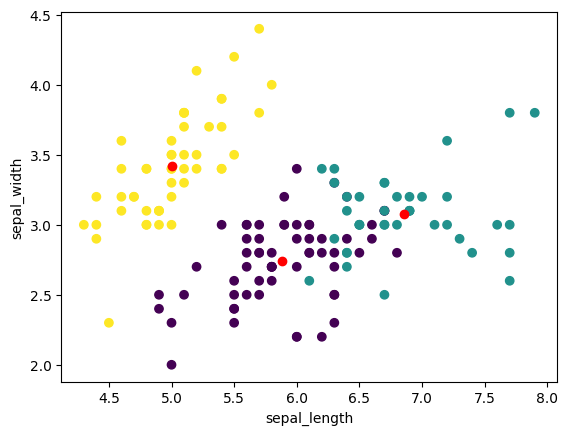

In [132]:
labels, centers = kmean(X_data, 3, euclidean)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width") 

[[5.  2.  3.5 1. ]
 [5.8 2.7 4.1 1. ]
 [5.1 3.5 1.4 0.3]]
0.6601464870925771


Text(0, 0.5, 'sepal_width')

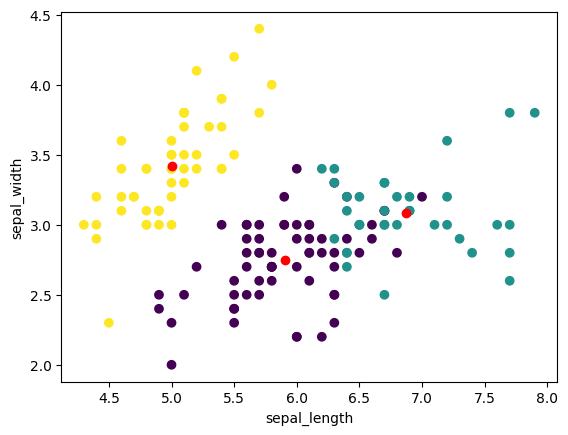

In [79]:
labels, centers = kmean(X_data, 3, manhattan)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[5.8 2.7 3.9 1.2]
 [6.4 3.2 4.5 1.5]
 [6.8 3.  5.5 2.1]]
0.663046326431084


Text(0, 0.5, 'sepal_width')

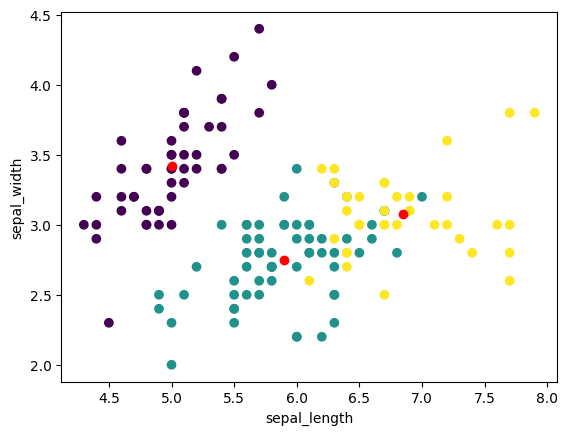

In [80]:
labels, centers = kmean(X_data, 3, sum_sq)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[5.1 2.5 3.  1.1]
 [6.7 3.  5.  1.7]]
k = 2
[[5.2 2.7 3.9 1.4]
 [5.6 3.  4.5 1.5]
 [5.  3.4 1.5 0.2]]
k = 3
[[5.8 2.7 3.9 1.2]
 [5.2 3.4 1.4 0.2]
 [6.5 3.  5.5 1.8]
 [4.9 3.1 1.5 0.1]]
k = 4
[[5.4 3.9 1.7 0.4]
 [5.8 2.7 5.1 1.9]
 [6.7 3.3 5.7 2.5]
 [6.3 2.8 5.1 1.5]
 [7.6 3.  6.6 2.1]]
k = 5
[[5.6 2.5 3.9 1.1]
 [5.  3.4 1.5 0.2]
 [5.6 3.  4.5 1.5]
 [5.8 2.6 4.  1.2]
 [5.2 4.1 1.5 0.1]
 [6.9 3.1 5.1 2.3]]


k = 6


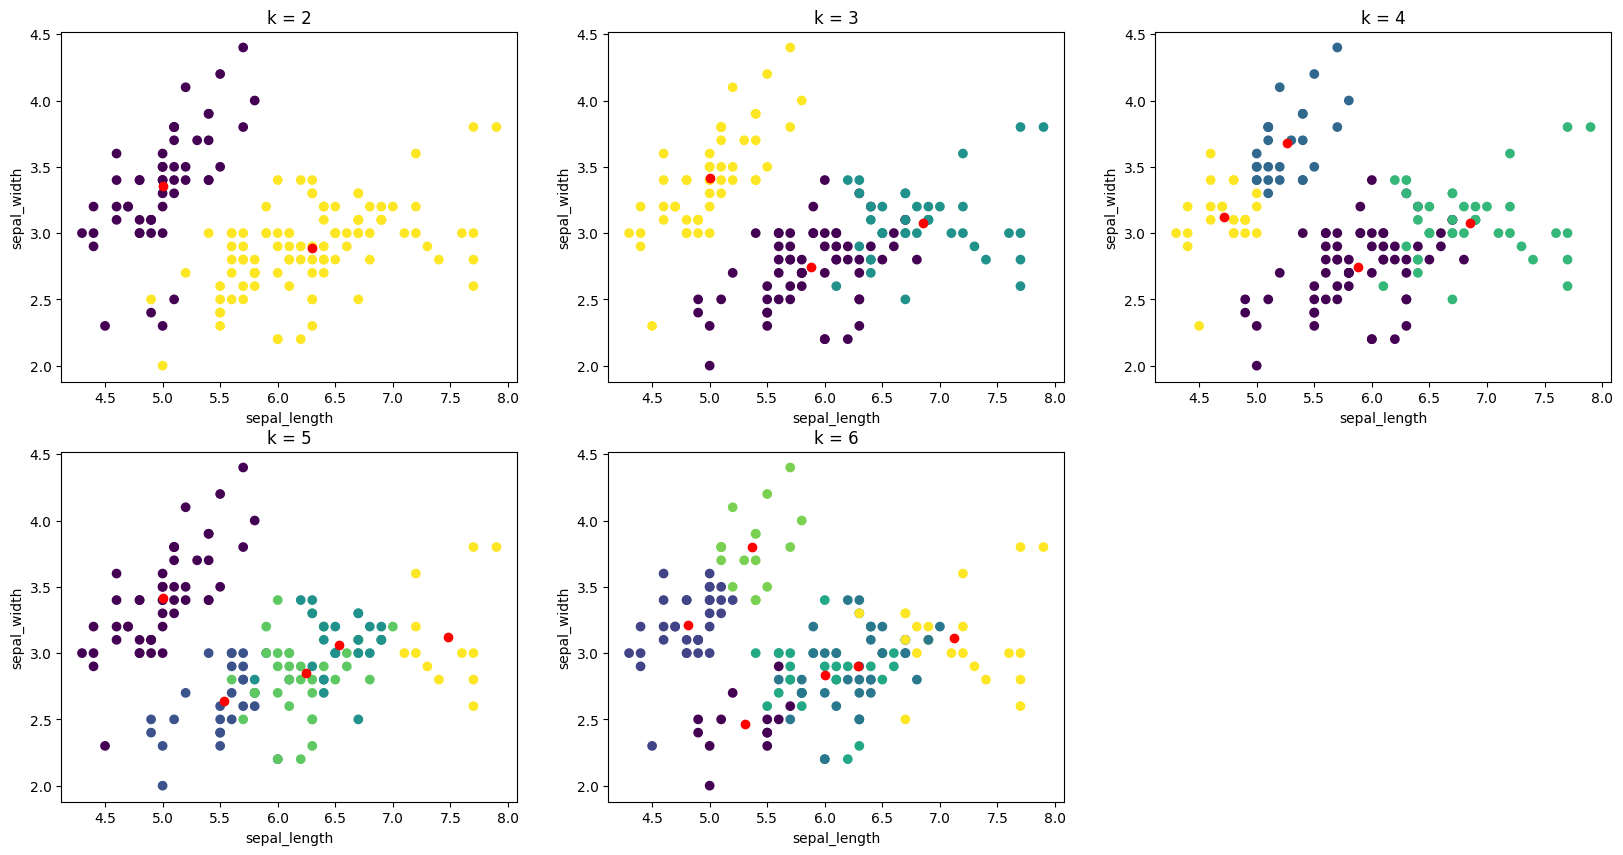

In [8]:
# apply k mean with k in k and subplot
list = []
for i in k:
    labels, centers = kmean(X_data, i, euclidean)
    print(f"k = {i}")
    list.append(metrics.davies_bouldin_score(X_data, labels))
    
    plt.subplot(2, 3, i - 1)
    plt.title(f"k = {i}")
    plt.gcf().set_size_inches(20, 10)
    plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
    plt.scatter(centers[:,0], centers[:,1], c="red")
    # add name of x and y 
    plt.xlabel("sepal_length")
    plt.ylabel("sepal_width")
plt.show()

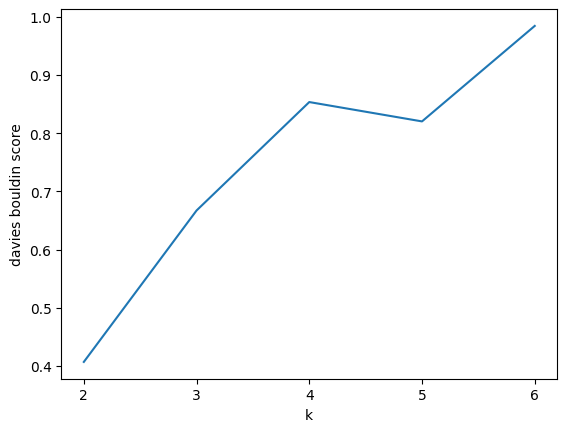

In [9]:
# plot the davies bouldin score with k is int
plt.plot(k, list)
plt.xlabel("k")
plt.xticks(k)
plt.ylabel("davies bouldin score")
plt.show()

# Different k on rice dataset

In [81]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

[[1.11150000e+04 4.24730011e+02 1.77785416e+02 8.05449448e+01
  8.91487241e-01 1.13180000e+04 7.34633207e-01]
 [1.27520000e+04 4.62359985e+02 1.90734177e+02 8.66717606e+01
  8.90792012e-01 1.31120000e+04 6.28425002e-01]]
0.5273001110862959


Text(0, 0.5, 'sepal_width')

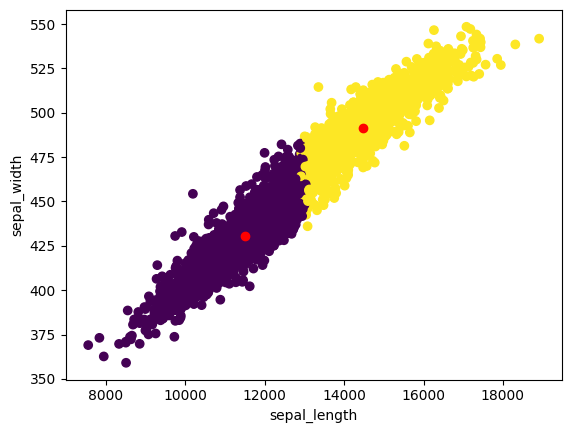

In [84]:
labels, centers = kmean(X_data, 2, euclidean)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[1.15530000e+04 4.33777008e+02 1.83221375e+02 8.09451447e+01
  8.97119105e-01 1.17290000e+04 8.06773722e-01]
 [1.39230000e+04 4.62700012e+02 1.89525711e+02 9.45252151e+01
  8.66748095e-01 1.41860000e+04 7.29946554e-01]]
0.5274130356851247


Text(0, 0.5, 'sepal_width')

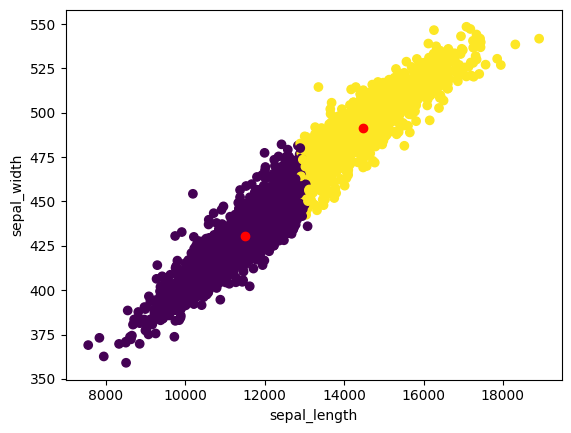

In [86]:
labels, centers = kmean(X_data, 2, manhattan)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[1.08800000e+04 3.94644989e+02 1.53794815e+02 9.09881821e+01
  8.06216478e-01 1.10570000e+04 7.47766316e-01]
 [1.21010000e+04 4.35928986e+02 1.78397324e+02 8.69837646e+01
  8.73075843e-01 1.23020000e+04 7.40575254e-01]
 [1.50930000e+04 5.09304993e+02 2.14428116e+02 9.08832779e+01
  9.05736923e-01 1.54970000e+04 5.72615504e-01]]
0.5561180517992933


Text(0, 0.5, 'sepal_width')

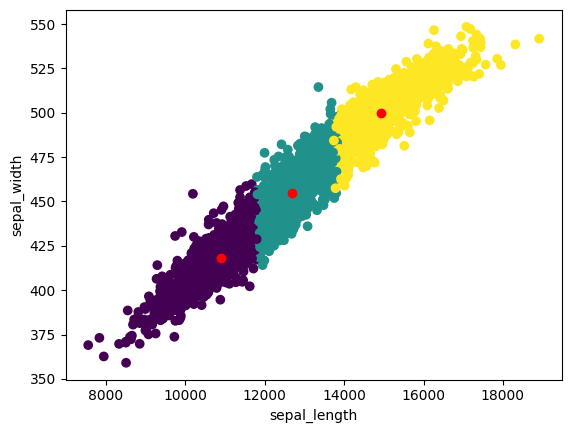

In [87]:
labels, centers = kmean(X_data, 3, sum_sq)
print(metrics.davies_bouldin_score(X_data, labels))
plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

[[1.42760000e+04 4.92839996e+02 2.08876953e+02 8.81210861e+01
  9.06651497e-01 1.47060000e+04 5.82456112e-01]
 [1.24110000e+04 4.43554993e+02 1.78227219e+02 9.02240448e+01
  8.62398267e-01 1.27800000e+04 6.40534699e-01]]
k = 2
[[1.51430000e+04 5.04140015e+02 2.07734177e+02 9.41483841e+01
  8.91400874e-01 1.56280000e+04 5.71326137e-01]
 [1.19530000e+04 4.43518005e+02 1.83425735e+02 8.45471725e+01
  8.87434363e-01 1.22830000e+04 5.70712388e-01]
 [1.11790000e+04 4.18709991e+02 1.71108383e+02 8.45663910e+01
  8.69332850e-01 1.14400000e+04 7.35605717e-01]]
k = 3
[[9.99400000e+03 4.06643005e+02 1.73098511e+02 7.44651566e+01
  9.02738631e-01 1.01230000e+04 8.07009041e-01]
 [1.51260000e+04 5.00114014e+02 2.09166809e+02 9.38142090e+01
  8.93775880e-01 1.54960000e+04 7.06030607e-01]
 [1.35620000e+04 4.74218994e+02 1.94612762e+02 9.06689758e+01
  8.84840369e-01 1.38710000e+04 7.13338971e-01]
 [9.93300000e+03 3.97720001e+02 1.60850632e+02 7.97827682e+01
  8.68319452e-01 1.01610000e+04 7.06371784e-

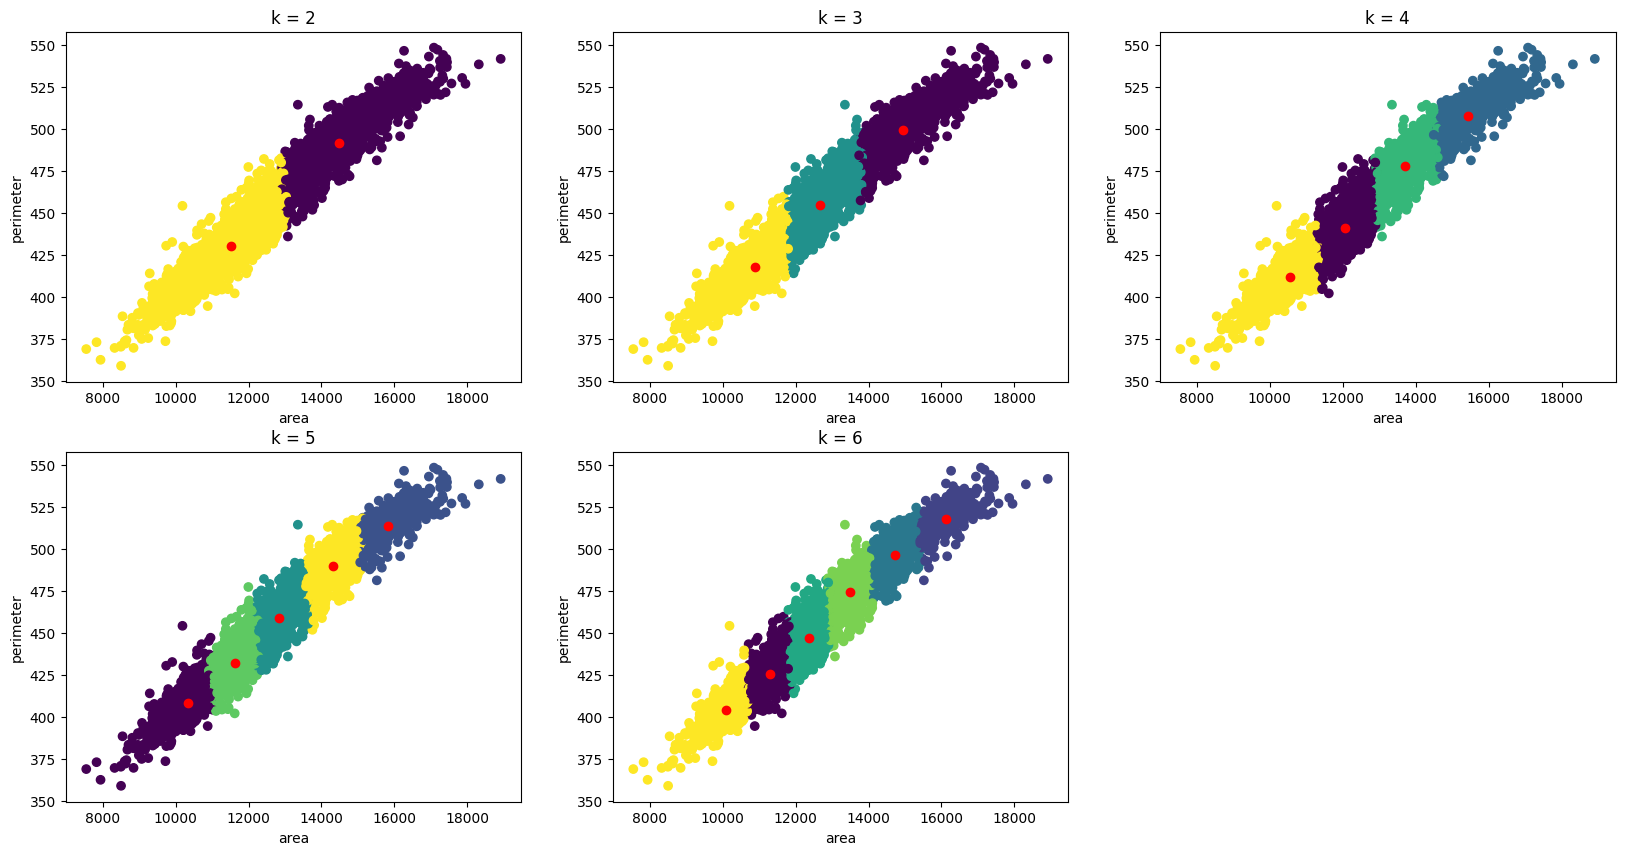

In [26]:
# apply k mean with k in k and subplot
list = []
for i in k:
    labels, centers = kmean(X_data, i, euclidean)
    print(f"k = {i}")
    list.append(metrics.davies_bouldin_score(X_data, labels))
    
    plt.subplot(2, 3, i - 1)
    plt.title(f"k = {i}")
    plt.gcf().set_size_inches(20, 10)
    plt.scatter(X_data[:,0], X_data[:,1], c=labels, cmap="viridis")
    plt.scatter(centers[:,0], centers[:,1], c="red")
    # add name of x and y 
    plt.xlabel("area")
    plt.ylabel("perimeter")
plt.show()

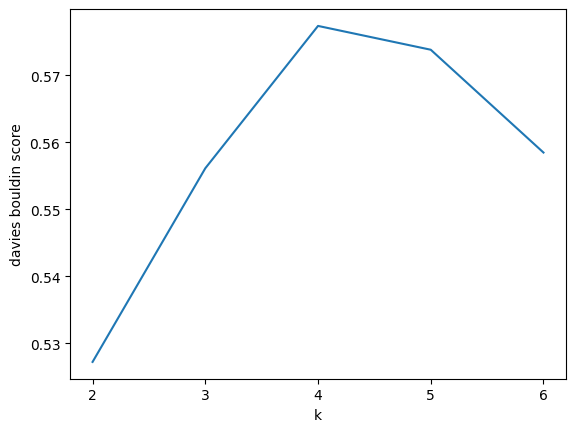

In [27]:
# plot the davies bouldin score with k is int
plt.plot(k, list)
plt.xlabel("k")
plt.xticks(k)
plt.ylabel("davies bouldin score")
plt.show()

# Apply PCA and then Kmean for iris dataset

In [134]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

[[ 1.27799588  0.32739624]
 [-2.60676122  0.19129755]
 [-2.64423265 -0.17657389]]
loop 2


Text(0, 0.5, 'PC2')

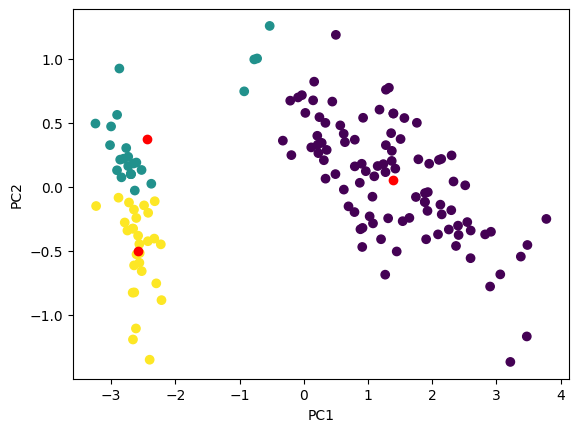

In [166]:
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])
pca = pca.project(2).drop(columns=["class"])
labels, centers = kmean(pca.values, 3, euclidean)
plt.scatter(pca.values[:,0], pca.values[:,1], c=labels)
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [163]:
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca.values, labels))

Davies Bouldin Score:  0.5656970645543343


[[-3.24397251 -1.36784329]
 [ 0.26656464 -0.0541311 ]
 [ 3.77710179  1.2595811 ]]
loop 2


Text(0, 0.5, 'PC2')

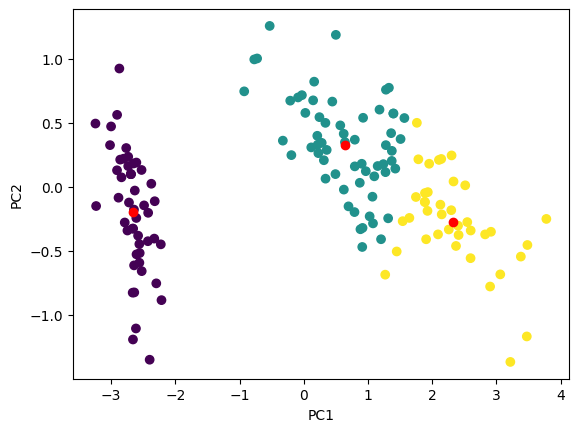

In [167]:
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])
pca = pca.project(2).drop(columns=["class"])
intial_centers = distribute_centroids(pca.values, 3)
labels, centers = kmean(pca.values, 3, euclidean, intial_centers)
plt.scatter(pca.values[:,0], pca.values[:,1], c=labels)
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Apply Kmean and then PCA for iris dataset

In [20]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

[[6.  3.4 4.5 1.6]
 [6.6 2.9 4.6 1.3]
 [5.8 2.7 4.1 1. ]]


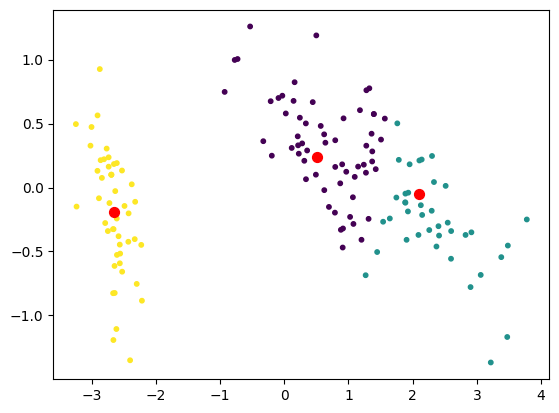

In [24]:
labels, centers = kmean(X_data, 3, euclidean)
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])
pca_data = pca.project(2)
plt.scatter(pca_data.values[:,0], pca_data.values[:,1], c=labels, s=10)
plt.scatter(pca_data.groupby("class").mean()["PC1"], pca_data.groupby("class").mean()["PC2"], c='red', s=50)

In [41]:
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca_data.drop(columns=["class"]).values, labels))

Davies Bouldin Score:  0.5656970645543343


# Apply PCA and then Kmean for rice dataset

In [9]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

In [10]:
pca = PCA(X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']] , X['class'])

[[ 2178.96456545   -47.44225776]
 [-4405.11695203   -89.74239293]]


Text(0, 0.5, 'PC2')

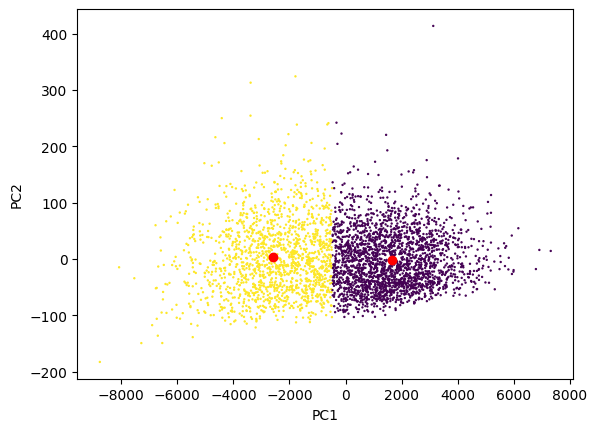

In [11]:
pca = pca.project(2).drop(columns=["class"])
labels, centers = kmean(pca.values, 2, euclidean)
plt.scatter(pca.values[:,0], pca.values[:,1], c=labels, s=0.5)
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [22]:
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca.values, labels))

Davies Bouldin Score:  0.5272309033554218


# Apply Kmean and then PCA for Rice dataset

In [14]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

[[1.39730000e+04 4.74007996e+02 1.92349289e+02 9.37791443e+01
  8.73097241e-01 1.43540000e+04 6.14197791e-01]
 [1.28400000e+04 4.54404999e+02 1.84815186e+02 8.99216232e+01
  8.73653352e-01 1.31850000e+04 7.26655364e-01]]


Text(0, 0.5, 'PC2')

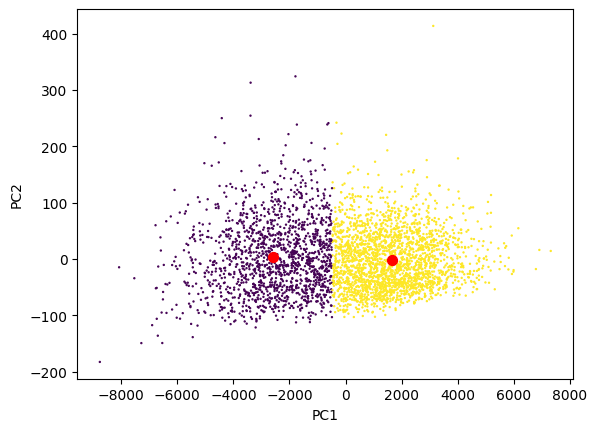

In [16]:
labels, centers = kmean(X_data, 2, euclidean)
pca = PCA(X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']] , labels)
# plot the centroids of pca
pca_data = pca.project(2)
plt.scatter(pca_data.values[:,0], pca_data.values[:,1], c=labels, s=0.5)
plt.scatter(pca_data.groupby("class").mean()["PC1"], pca_data.groupby("class").mean()["PC2"], c='red', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")

In [25]:
pca_data = pca_data.drop(columns=["class"])
print("Davies Bouldin Score: ", metrics.davies_bouldin_score(pca_data.values, labels))

Davies Bouldin Score:  0.5272309033554218
